In [1]:
import torch
from torch import nn
import transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. summary

- ffn: 两层的MLP
    - 两个细节：
        - h->4h->h
        - gelu
- layer normalization
- skip connection

In [2]:
from transformers import AutoTokenizer,AutoModel,AutoConfig
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)
config


BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [3]:
def scaled_dot_product_attention(query,key,value):
    dim_k = key.size(-1)
    attn_scores = torch.bmm(query,key.transpose(1,2)/np.sqrt(dim_k))
    attn_weights = F.softmax(attn_scores,dim=-1)
    return torch.bmm(attn_weights,value)

In [12]:
import torch.nn.functional as F
class Attentionhead(nn.Module):
    def __init__(self, embed_dim, head_dim) -> None:
        super().__init__()
        self.Wq = nn.Linear(embed_dim, head_dim)
        self.Wk = nn.Linear(embed_dim, head_dim)
        self.Wv = nn.Linear(embed_dim, head_dim)

    def forward(self, hidden_states):
        q = self.Wq(hidden_states)
        k = self.Wk(hidden_states)
        v = self.Wv(hidden_states)
        return scaled_dot_product_attention(q, k, v)


class MultiHeadAttention(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        embed_dim = config.hidden_size
        num_heads = config.num_attention_heads
        head_dim = embed_dim//num_heads
        # self.heads = nn.ModuleList(
        #     [Attentionhead(embed_dim, head_dim) for _ in range(num_heads)]
        # )
        self.heads = nn.ModuleList([
            Attentionhead(embed_dim, head_dim) for _ in range(num_heads)
        ])
        self.output_layer = nn.Linear(embed_dim, embed_dim)

    def forward(self, hidden_state):
        print(f"hidden_state shape:{hidden_state.shape}")
        print(f'head(hidden_state): {self.heads[11](hidden_state).shape}')
        x = torch.cat([head(hidden_state) for head in self.heads], dim=-1)
        print(f'cat heads: {x.shape}')
        x = self.output_layer(x)
        return x

In [13]:
mha = MultiHeadAttention(config)

In [14]:
# input
# config.vocab_size: 30522, 
# config.hidden_size: 768=64*12
# lookup-table, learnable
token_embedding = nn.Embedding(config.vocab_size, config.hidden_size)
# token_embedding
sample_text = 'time flies like an arrow'
model_inputs = tokenizer(sample_text, return_tensors='pt', add_special_tokens=False)
# forward of embedding module
input_embeddings = token_embedding(model_inputs['input_ids'])
# batch_size, seq_len, hidden_size
input_embeddings.shape

torch.Size([1, 5, 768])

In [15]:
attn_output = mha(input_embeddings)

hidden_state shape:torch.Size([1, 5, 768])
head(hidden_state): torch.Size([1, 5, 64])
cat heads: torch.Size([1, 5, 768])


## FFN
- Relu: x if x>0
- Gelu: https://paperswithcode.com/method/gelu
    - $\Phi(x) = \frac{1+Erf(\frac{x}{\sqrt{2}})}{2}$

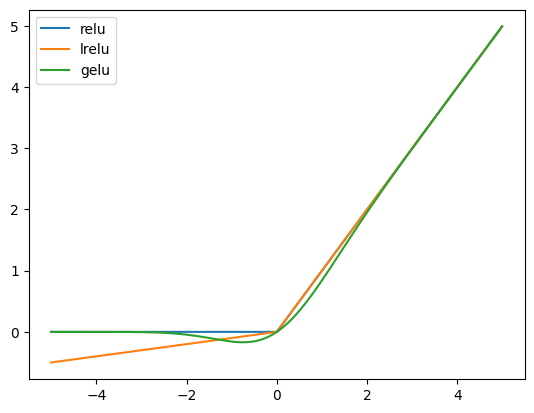

In [7]:
x = np.arange(-5, 5, 0.01)
plt.plot(x, nn.ReLU()(torch.from_numpy(x)))
plt.plot(x, nn.LeakyReLU(negative_slope=0.1)(torch.from_numpy(x)))
plt.plot(x, nn.GELU()(torch.from_numpy(x)))
plt.legend(['relu', 'lrelu', 'gelu'])

In [9]:
class FeedForward(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        # config.intermediate_size: 4*h == 4*768 == 3072
        # (intermediate)
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        # (output)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, x):
        # b, s, h => b, s, 4h
        x = self.fc1(x)
        x = self.gelu(x)
        # b, s, 4h => b, s, h
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [10]:
ffn = FeedForward(config)

In [17]:
ffn(attn_output).shape

torch.Size([1, 5, 768])

## 4 layer norm && skip connection
- layer norm(config, "layer_norm_eps":1e-12,)
    - zero mean & one variance
    - 与 batch norm 相对，是样本层面
    - 对与 nlp 问题，一般是每一个 token 对应的 embedding （也就是 768 维 的 hidden state 进行 0 均值 1 标准差的归一化）
- 在 transformers 中主要是两处用到了 layer norm embedding
    - 对于最终的 token_embedding
    - 构建 bert layer（或者叫 transformer encoder layer）

## 5 encoder layer

In [18]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        # 768, embedding 级别进行 0均值 1 标准差的归一化处理
        self.ln1 = nn.LayerNorm(config.hidden_size)
        # 768, embedding 级别进行 0均值 1 标准差的归一化处理
        self.ln2 = nn.LayerNorm(config.hidden_size)
        self.attn = MultiHeadAttention(config)
        self.ffn = FeedForward(config)
    def forward(self, x):
        # x from embedding, (b, s, h)
        x = x + self.attn(self.ln1(x))
        x = x + self.ffn(self.ln2(x))
        # (b, s, h)
        return x

In [20]:
encode_layer = TransformerEncoderLayer(config)
encode_layer

TransformerEncoderLayer(
  (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (attn): MultiHeadAttention(
    (heads): ModuleList(
      (0-11): 12 x Attentionhead(
        (Wq): Linear(in_features=768, out_features=64, bias=True)
        (Wk): Linear(in_features=768, out_features=64, bias=True)
        (Wv): Linear(in_features=768, out_features=64, bias=True)
      )
    )
    (output_layer): Linear(in_features=768, out_features=768, bias=True)
  )
  (ffn): FeedForward(
    (fc1): Linear(in_features=768, out_features=3072, bias=True)
    (fc2): Linear(in_features=3072, out_features=768, bias=True)
    (gelu): GELU(approximate='none')
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [21]:
encode_layer(input_embeddings).shape

hidden_state shape:torch.Size([1, 5, 768])
head(hidden_state): torch.Size([1, 5, 64])
cat heads: torch.Size([1, 5, 768])


torch.Size([1, 5, 768])